In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation ,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc,precision_score, recall_score,f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt
from skimage import transform
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as ktf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

170500096/170498071 [==============================] - 2s 0us/step
Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


In [3]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

In [4]:
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

X_train /= 255.0
mean = np.mean(X_train, axis=(0, 1, 2,3))
std = np.std(X_train, axis=(0, 1, 2,3))
X_train = (X_train - mean)/ (std+1e-7)

x_test /= 255.0

x_test =(x_test-mean) / (std+1e-7)

print(X_train.shape)
print(x_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [6]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [7]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-m7du4tur
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-m7du4tur
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20031 sha256=1f875b133ac6385efda4f1daa449a179c518ceb57b2431219be88d3d145869f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9aof4g7/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [8]:
from classification_models.tfkeras import Classifiers

In [9]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18 = ResNet18((224, 224, 3), weights='imagenet')
resnet18.summary() 

46981120/46977688 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
______________________

In [10]:
alpha = 0.003  # weight decay coefficient

for layer in resnet18.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

In [11]:
x = resnet18.layers[-2].output
output = Dense(units=10,activation='softmax')(x)
model = Model(inputs=[resnet18.input], outputs=[output])
#model.summary()

In [12]:
for layer in model.layers[35:]:
    layer.trainable = True
for layer in model.layers[:35]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 data False
1 bn_data False
2 zero_padding2d False
3 conv0 False
4 bn0 False
5 relu0 False
6 zero_padding2d_1 False
7 pooling0 False
8 stage1_unit1_bn1 False
9 stage1_unit1_relu1 False
10 zero_padding2d_2 False
11 stage1_unit1_conv1 False
12 stage1_unit1_bn2 False
13 stage1_unit1_relu2 False
14 zero_padding2d_3 False
15 stage1_unit1_conv2 False
16 stage1_unit1_sc False
17 add False
18 stage1_unit2_bn1 False
19 stage1_unit2_relu1 False
20 zero_padding2d_4 False
21 stage1_unit2_conv1 False
22 stage1_unit2_bn2 False
23 stage1_unit2_relu2 False
24 zero_padding2d_5 False
25 stage1_unit2_conv2 False
26 add_1 False
27 stage2_unit1_bn1 False
28 stage2_unit1_relu1 False
29 zero_padding2d_6 False
30 stage2_unit1_conv1 False
31 stage2_unit1_bn2 False
32 stage2_unit1_relu2 False
33 zero_padding2d_7 False
34 stage2_unit1_conv2 False
35 stage2_unit1_sc True
36 add_2 True
37 stage2_unit2_bn1 True
38 stage2_unit2_relu1 True
39 zero_padding2d_8 True
40 stage2_unit2_conv1 True
41 stage2_unit2_bn2 True


In [13]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: ktf.image.resize(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

In [14]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

step = tf.Variable(0, trainable=False)
boundaries = [40*STEPS_PER_EPOCH,60*STEPS_PER_EPOCH,80*STEPS_PER_EPOCH]
values = [ 0.1, 0.01,0.001,0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [15]:
opt = SGD(learning_rate=learning_rate_fn)#,momentum=0.9,decay=0.01,nesterov=False
#opt = Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.99,epsilon=0.1,amsgrad=False,name="Adam",)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [17]:
history =model.fit(X_train, y_train, batch_size=100,
                   steps_per_epoch=len(X_train) // 100,epochs=100,
                   validation_data=(x_test,y_test))

Epoch 1/100
500/500 [==============================] - 109s 217ms/step - loss: 3.0047 - accuracy: 0.2704 - val_loss: 5.8201 - val_accuracy: 0.1053
Epoch 2/100
500/500 [==============================] - 109s 219ms/step - loss: 1.1181 - accuracy: 0.6204 - val_loss: 3.3272 - val_accuracy: 0.1687
Epoch 3/100
500/500 [==============================] - 110s 220ms/step - loss: 0.7909 - accuracy: 0.7456 - val_loss: 2.8515 - val_accuracy: 0.2136
Epoch 4/100
500/500 [==============================] - 110s 219ms/step - loss: 0.6210 - accuracy: 0.8066 - val_loss: 3.1717 - val_accuracy: 0.2761
Epoch 5/100
500/500 [==============================] - 110s 219ms/step - loss: 0.4975 - accuracy: 0.8472 - val_loss: 1.6755 - val_accuracy: 0.4726
Epoch 6/100
500/500 [==============================] - 110s 219ms/step - loss: 0.4029 - accuracy: 0.8805 - val_loss: 1.6751 - val_accuracy: 0.5675
Epoch 7/100
500/500 [==============================] - 110s 219ms/step - loss: 0.3166 - accuracy: 0.9092 - val_loss: 1

In [18]:
#model.save('cifar10.simplenet2.h5')
                 
#model=load_model('cifar10_01.h5')

In [19]:
y_pred = model.predict(x_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round()))) 

Auc = 0.926217
f1_score = 0.878494
precision = 0.894163
recall  = 0.863700
accuracy  = 0.863700


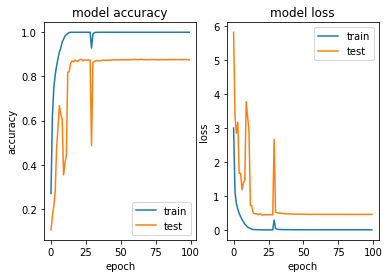

In [20]:
plothist(history)